Fake News Detector

In [133]:
# import "true news" and "fake news" datasets

import pandas as pd

df_true = pd.read_csv('True.csv')
df_fake = pd.read_csv('Fake.csv')

df_true = df_true.sample(n=5000, random_state=42).reset_index(drop=True)
df_fake = df_fake.sample(n=5000, random_state=42).reset_index(drop=True)

In [135]:
# preprocess the datasets

import spacy
import re
from tqdm import tqdm

tqdm.pandas()

nlp = spacy.load('en_core_web_sm')

def preprocess(text):
    text = re.sub(r'\breuters?\b', '', text, flags=re.IGNORECASE)
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    return " ".join(tokens)

df_true['title'] = df_true['title'].progress_apply(preprocess)
print("'Title' preprocessed!")
df_true['text'] = df_true['text'].progress_apply(preprocess)
print("'Text' preprocessed!")

df_fake['title'] = df_fake['title'].progress_apply(preprocess)
print("'Title' preprocessed!")
df_fake['text'] = df_fake['text'].progress_apply(preprocess)
print("'Text' preprocessed!")

100%|██████████| 5000/5000 [00:47<00:00, 105.74it/s]


'Title' preprocessed!


100%|██████████| 5000/5000 [07:34<00:00, 10.99it/s]


'Text' preprocessed!


100%|██████████| 5000/5000 [00:52<00:00, 95.43it/s] 


'Title' preprocessed!


100%|██████████| 5000/5000 [08:14<00:00, 10.10it/s]

'Text' preprocessed!


In [136]:
# introduce a new "target" column with value "1" for true news indicating a true news and "0" for fake news indicating a fake news in both datasets

df_true['target'] = 1
df_fake['target'] = 0

print(df_true.head(10))
print(df_fake.head(10))

                                               title  \
0  europe right watchdog say turkey emergency law...   
1  exclusive trump target illegal immigrant give ...   
2            summit trump pledge million aid country   
3  ex christie associate lose bid new trial bridg...   
4    young black open bernie sanders white house bid   
5  new york attorney general say sue obamacare re...   
6  indonesian parliament speaker quit amid graft ...   
7  spanish lender sabadell transfer legal base al...   
8  house speaker tell trump healthcare bill lack ...   
9          britain say expect eu citizen stay brexit   

                                                text       subject  \
0  brussels lead european right watchdog call tur...     worldnews   
1  september gilberto velasquez year old house pa...  politicsNews   
2  hamburg president donald trump saturday promis...  politicsNews   
3  new york federal judge reject request new tria...  politicsNews   
4  orangeburg democratic hopeful 

In [137]:
# merge true and fake news datasets

df = pd.concat([df_true, df_fake], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [139]:
# generate and download the new news dataset (just in case)

df.to_csv("preprocessed_news_data_mixed.csv", index=False)

from google.colab import files
files.download("preprocessed_news_data_mixed.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
# continuation

import pandas as pd

df = pd.read_csv('preprocessed_news_data_mixed.csv')

In [141]:
print(df.head(10))

                                               title  \
0  secret service laptop reportedly steal trump t...   
1  trump shuffle transition team eye loyalist cab...   
2               trump plan comey fbi director source   
3       south korea china hold summit month mend tie   
4            trump tax plan manage pay growth expert   
5  insult fly obama town hall laos insult direct ...   
6  turkey want iraq kurdish region drop referendu...   
7         flashback mark steyn banana republic video   
8  stunning development obama give million tax do...   
9  trump say comment mexican american judge misco...   

                                                text       subject       date  \
0  century wire say laptop reportedly steal secre...       US_News 2017-10-06   
1  new york washington president elect donald tru...  politicsNews 2017-06-09   
2  washington president donald trump intend fbi d...  politicsNews 2017-07-08   
3  south korean president moon jae visit beijing ...     wo

In [5]:
# parse features out of "date" column in the datasets

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

df['dayofweek'] = df['date'].dt.dayofweek.astype(int)
df['month'] = df['date'].dt.month.astype(int)
df['year'] = df['date'].dt.year.astype(int)

/tmp/ipython-input-1079721126.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df['date'].dt.dayofweek.astype(int)
/tmp/ipython-input-1079721126.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['date'].dt.month.astype(int)
/tmp/ipython-input-1079721126.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [10]:
# drop "subject" and "date" columns now

df.drop(columns=['subject', 'date'], inplace=True)

In [11]:
# merge title and text columns as "news"

df['news'] = df['title'] + " " + df['text']

In [12]:
# drop "title" and "text" columns now

df.drop(columns=['title', 'text'], inplace=True)

In [13]:
# remove duplicates

df = df.drop_duplicates(subset=['news', 'target']).reset_index(drop=True)

In [15]:
# drop rows with empty, NaN/,NaT, null and "" columns

df.replace("", pd.NA, inplace=True)
df.dropna(inplace=True)

In [22]:
# convert the news dataset's title, text and date features columns into TF-IDF vectors

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_news = TfidfVectorizer()
vectorizer_year = TfidfVectorizer()
vectorizer_month = TfidfVectorizer()
vectorizer_dayofweek = TfidfVectorizer()
vectorizer_dayofweek = TfidfVectorizer(stop_words=None, token_pattern=r"(?u)\b\w+\b")

news = vectorizer_news.fit_transform(df['news'])
year = vectorizer_year.fit_transform(df['year'].astype(str))
month = vectorizer_month.fit_transform(df['month'].astype(str))
dayofweek = vectorizer_dayofweek.fit_transform(df['dayofweek'].astype(str))

In [24]:
# combine TF-IDF features from title and description into a single sparse matrix

from scipy.sparse import hstack

X = hstack([news, year, month, dayofweek])
y = df['target'].values

In [25]:
print(df.head(5))

   target  dayofweek  month  year  \
0       0          4      3  2017   
1       1          1     11  2016   
2       1          1      1  2017   
3       1          2     11  2017   
4       1          2      4  2017   

                                                news  
0  secret service laptop reportedly steal trump t...  
1  trump shuffle transition team eye loyalist cab...  
2  trump plan comey fbi director source washingto...  
3  south korea china hold summit month mend tie s...  
4  trump tax plan manage pay growth expert washin...  


In [42]:
# splitting dataset for testing and training sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# train, predict and evaluate with Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred, target_names=['0', '1']))
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       938
           1       0.96      0.97      0.97       977

    accuracy                           0.97      1915
   macro avg       0.97      0.97      0.97      1915
weighted avg       0.97      0.97      0.97      1915

Logistic Regression Accuracy: 0.9660574412532638


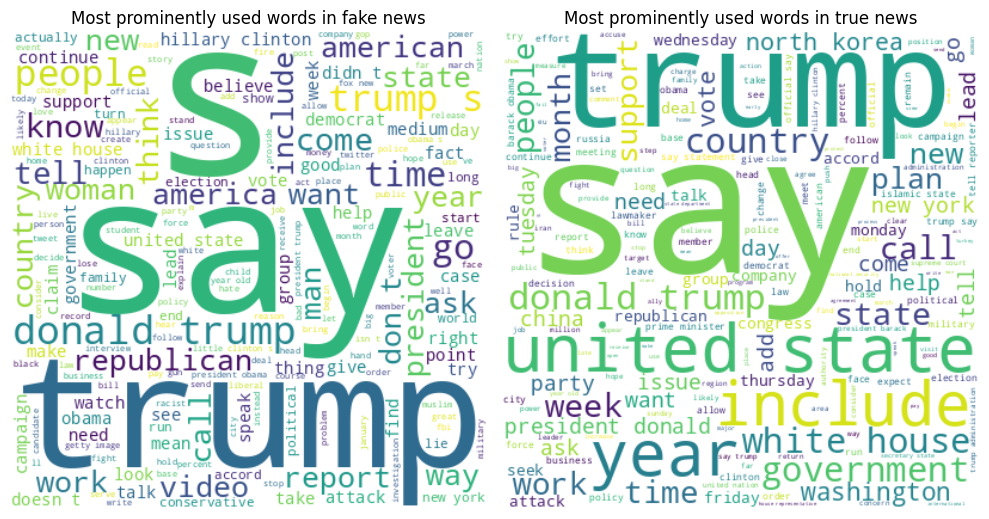

In [36]:
# bonus: visualizing most frequently used words in true news and fake news

import matplotlib.pyplot as plt
from wordcloud import WordCloud

fake_news_text = ' '.join(df[df['target'] == 0]['news'].dropna().astype(str))
true_news_text = ' '.join(df[df['target'] == 1]['news'].dropna().astype(str))

fake_news_wc = WordCloud(width=400, height=400, background_color='white').generate(fake_news_text)
true_news_wc = WordCloud(width=400, height=400, background_color='white').generate(true_news_text)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(fake_news_wc, interpolation='bilinear')
plt.title('Most prominently used words in fake news')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(true_news_wc, interpolation='bilinear')
plt.title('Most prominently used words in true news')
plt.axis('off')

plt.tight_layout()
plt.show()